<a href="https://colab.research.google.com/github/IqbalLx/Machine-Learning-Deep-Learning-Project/blob/master/Hanacaraka_AI_Iqbal_Maulana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hanacaraka AI - Iqbal Maulana
---

So this project is my previous project as a final project in Bangkit ML Academy held by Google. I believe Dicoding also one of their partner in this event.

We work in team, but my part is in the modeling section, so this code below is still my work too.

Also I use this project to compete in Future Ready ASEAN 2020, that carrying AI for culture theme. Fyi, our mentor for this competition is mas Yoza :D

You can visit the implementation of this model here [Hanacaraka AI](https://hanacarakaai.herokuapp.com)

## Prepare dataset from kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle                                                           # Installing required kaggle library
!mkdir ~/.kaggle                                                                 # Create new Kaggle directory to store our API key in root
!cp kaggle.json ~/.kaggle                                                        # Copy the API to root folder
!chmod 600 ~/.kaggle/kaggle.json                                                 # Give access
!kaggle datasets download -d phiard/aksara-jawa                                  # Downloading the dataset

In [ ]:
!unzip aksara-jawa.zip

Archive:  aksara-jawa.zip
  inflating: prediction/prediction/ba17.png  
  inflating: prediction/prediction/ba49.mine2.png  
  inflating: prediction/prediction/ca2.png  
  inflating: prediction/prediction/da5.png  
  inflating: prediction/prediction/dha11.png  
  inflating: prediction/prediction/ga16.png  
  inflating: prediction/prediction/ha0.png  
  inflating: prediction/prediction/ja12.png  
  inflating: prediction/prediction/ka4.png  
  inflating: prediction/prediction/la9.png  
  inflating: prediction/prediction/ma.0.jpg  
  inflating: prediction/prediction/ma.1.jpg  
  inflating: prediction/prediction/ma15.png  
  inflating: prediction/prediction/na1.png  
  inflating: prediction/prediction/nga19.png  
  inflating: prediction/prediction/nga220.pred.png  
  inflating: prediction/prediction/nya14.png  
  inflating: prediction/prediction/pa10.png  
  inflating: prediction/prediction/ra164.pred.png  
  inflating: prediction/prediction/ra3.png  
  inflating: prediction/prediction/sa7.

So this kinda new, now the dataset is got in version 3, I believe it contain new images since last time I train the model on it. 

## Dataset preview

In [ ]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as plt_image

plt.style.use('seaborn')

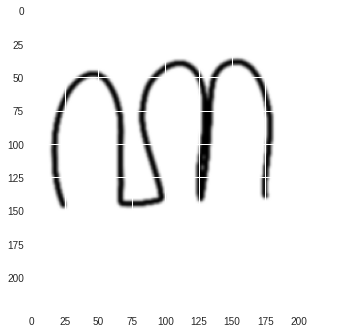

(224, 224, 3)


In [ ]:
preview = plt_image.imread('v3/v3/train/ha/ha0.meki.b.png')
plt.imshow(preview)
plt.show()
print(preview.shape)

single image is RGB (but we need grayscale only later), with shape 224 x 224

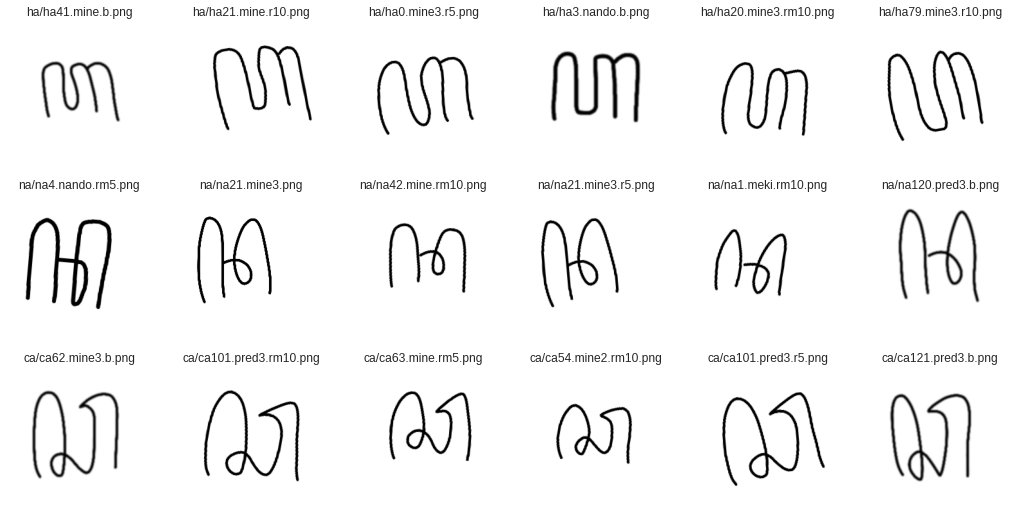

In [ ]:
TOTAL = 6                                                                        # Total of preview images
index = np.random.randint(20)                                                    # To randomize the index photo

plt.figure(figsize=(3*TOTAL, 9))

list_ha = [os.path.join('v3/v3/train/ha', name) for name in os.listdir('v3/v3/train/ha')[index:index+TOTAL]]
list_na = [os.path.join('v3/v3/train/na', name) for name in os.listdir('v3/v3/train/na')[index:index+TOTAL]]
list_ca = [os.path.join('v3/v3/train/ca', name) for name in os.listdir('v3/v3/train/ca')[index:index+TOTAL]]

for i, path in enumerate(list_ha+list_na+list_ca):
  plt.subplot(3, TOTAL, i+1)
  plt.axis('off')

  plt.title(path.replace('v3/v3/train/', ''))
  img = plt_image.imread(path)
  plt.imshow(img)

The author claim, that its all handwritten. We can see its quite diverse, whish is good

## Combining dataset

So since it require me to set 20% of total data as validation data and I dont know the ratio in val folder created by the author, I will combined all the dataset into single folder and  I will split it later when training,

In [ ]:
#@title Helper function to copy files
import shutil

sub_folder_name = os.listdir('v3/v3/train') 

def copy(SOURCE, DEST):
  for sub_folder in sub_folder_name:

    sub_folder_path = os.path.join(DEST, sub_folder)
    if not os.path.exists(sub_folder_path):
      os.mkdir(sub_folder_path)

    images = os.listdir(os.path.join(SOURCE, sub_folder))
    for image in images:
      path_source = f"{SOURCE}/{sub_folder}/{image}"
      path_dest = f"{DEST}/{sub_folder}/{image}"
      shutil.copyfile(path_source, path_dest)

  return print('200 OK')

In [ ]:
NEW_FOLDER = "datasets"

os.mkdir(NEW_FOLDER)

copy("v3/v3/train", NEW_FOLDER)
copy("v3/v3/val", NEW_FOLDER)

200 OK
200 OK


## Prepare Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
SIZE = 100 #Image width
SEED = 1  # Make sure random shuffle is same

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   shear_range=0.1, 
                                   validation_split=0.2)


val_datagen = ImageDataGenerator(rescale=1/255,
                                 validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'datasets',
    target_size=(SIZE, SIZE),
    batch_size=32,
    color_mode='grayscale',
    class_mode = 'categorical',
    seed=SEED, 
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    'datasets',
    target_size=(SIZE, SIZE),
    batch_size=32,
    color_mode='grayscale',
    class_mode = 'categorical',
    seed=SEED, 
    subset='validation',
)

Found 2115 images belonging to 20 classes.
Found 519 images belonging to 20 classes.


Well that's quite disappointing, last time I trained model on it, it contains 3000++ image just for training dataset, I think the author remove some of the images :(

## Modeling

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential([Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu', input_shape=(SIZE, SIZE, 1)),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(5e-5), activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(2, 2),
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Flatten(),
                    Dense(20, activation='softmax')])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-2),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 16)      160       
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 100, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 32)       

In [ ]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto',
                    min_delta=0.0001, cooldown=3, min_lr=1e-8
                )

In [ ]:
class EarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get("val_accuracy") > 0.95:
      self.model.stop_training = True

In [ ]:
history = model.fit(
          train_generator,
          epochs = 100,
          steps_per_epoch = int(2115/32),
          validation_data = val_generator,
          validation_steps= int(519/32),
          callbacks=[reduce_on_plateau, EarlyStop()],
          verbose=1
      )

Epoch 1/100
66/66 [==============================] - 6s 85ms/step - loss: 2.6288 - accuracy: 0.2156 - val_loss: 6.4278 - val_accuracy: 0.0488
Epoch 2/100
66/66 [==============================] - 5s 80ms/step - loss: 1.6379 - accuracy: 0.5161 - val_loss: 5.0251 - val_accuracy: 0.1055
Epoch 3/100
66/66 [==============================] - 5s 79ms/step - loss: 0.9470 - accuracy: 0.7412 - val_loss: 9.6427 - val_accuracy: 0.0508
Epoch 4/100
66/66 [==============================] - 5s 80ms/step - loss: 0.6819 - accuracy: 0.8099 - val_loss: 7.5189 - val_accuracy: 0.0703
Epoch 5/100
66/66 [==============================] - 5s 80ms/step - loss: 0.5979 - accuracy: 0.8526 - val_loss: 8.4386 - val_accuracy: 0.0508
Epoch 6/100
66/66 [==============================] - 5s 80ms/step - loss: 0.5139 - accuracy: 0.8824 - val_loss: 1.2249 - val_accuracy: 0.7207
Epoch 7/100
66/66 [==============================] - 5s 81ms/step - loss: 0.5095 - accuracy: 0.8824 - val_loss: 2.3014 - val_accuracy: 0.4434
Epoch 

## Plot training result

In [ ]:
def plot(history):
  graf = history.history
  graf['epoch'] = history.epoch

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

  ax[0].plot(graf['epoch'], graf['loss'], label='Loss')
  ax[0].plot(graf['epoch'], graf['val_loss'], label='Val Loss', color='orange')

  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Score')
  ax[0].set_title('Loss')
  ax[0].legend()

  ax[1].plot(graf['epoch'], graf['accuracy'], label='Accuracy')
  ax[1].plot(graf['epoch'], graf['val_accuracy'], label='Val Accuracy', color='orange')

  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Score')
  ax[1].set_title('Accuracy')
  ax[1].legend()

  ax[2].plot(graf['epoch'], graf['lr'], label='Learning Rate')

  ax[2].set_xlabel('Epochs')
  ax[2].set_ylabel('Value')
  ax[2].set_title('Learning Rate')

  return plt.show()

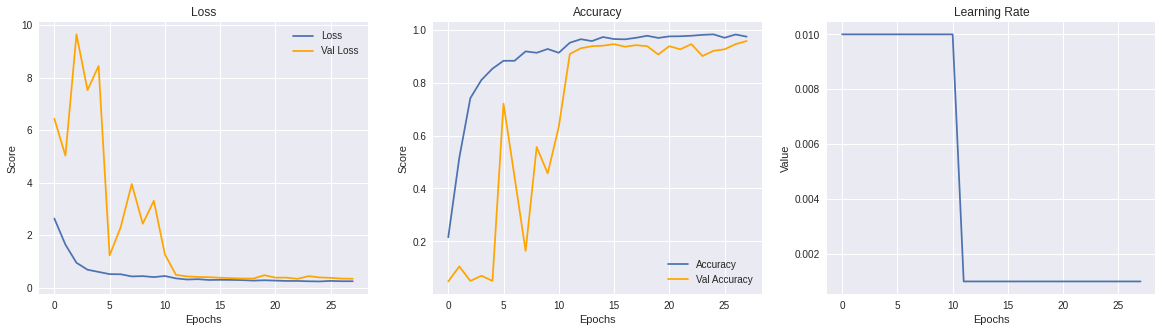

In [ ]:
plot(history)

## Saving into .tflite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('hancarakaai.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpd6b3fdmo/assets
